In [ ]:
%pip install gibbs_sampler adjustText biopython matplotlib bs4 requests pillow numpy

In [78]:
import Bio
from Bio import Entrez, SeqIO
from Bio.SeqRecord import SeqRecord
import requests
import bs4
from bs4 import BeautifulSoup
import PIL
from PIL import Image
import adjustText
from adjustText import adjust_text
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

import sys
import subprocess
import os


In [80]:
print(f'Python {(sys.version.split(" ")[0])}')
print(f'Biopython {Bio.__version__}')
print(f'Requests {requests.__version__}')
print(f'Beautifulsoup4 {bs4.__version__}')
print(f'Pillow {PIL.__version__}')
print(f'AdjustText {adjustText.__version__}')
print(f'Matplotlib {matplotlib.__version__}')
print(f'Numpy {np.__version__}')

Python 3.11.1
Biopython 1.80
Requests 2.28.1
Beautifulsoup4 4.11.2
Pillow 9.4.0
AdjustText 0.8
Matplotlib 3.6.2
Numpy 1.23.5


In [11]:
def parse_kegg_page(url):
    """Function to parse KO/Gene/Compound list page from KEGG module"""
    """url example: https://www.kegg.jp/kegg-bin/module_ko_list?map=map&org=org. 
       org: KEGG organism code,
       map: KEGG ID of the module
       """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    data = {}

    # Parse KEGG module
    kegg_module_table = soup.find_all('table')[0]
    module_id = kegg_module_table.find('a').text
    module_name = kegg_module_table.find('td').find_next_sibling('td').text
    data['KEGG module'] = {'id': module_id, 'name': module_name}

    # Parse KO list
    ko_table = soup.find(id='ko').find('table')
    ko_list = []
    for row in ko_table.find_all('tr')[1:]:
        ko_id = row.find('a').text
        ko_name = row.find('td').find_next_sibling('td').text
        ko_list.append({'id': ko_id, 'name': ko_name})
    data['KO list'] = ko_list

    # Parse Gene list
    gene_table = soup.find(id='gene').find('table')
    gene_list = []
    for row in gene_table.find_all('tr')[1:]:
        gene_id = row.find('a').text
        gene_name = row.find('td').find_next_sibling('td').text
        gene_list.append({'id': gene_id, 'name': gene_name})
    data['Gene list'] = gene_list

    # Parse Compound list
    cpd_table = soup.find(id='cpd').find('table')
    cpd_list = []
    for row in cpd_table.find_all('tr')[1:]:
        cpd_id = row.find('a').text
        cpd_name = row.find('td').find_next_sibling('td').text
        cpd_list.append({'id': cpd_id, 'name': cpd_name})
    data['Compound list'] = cpd_list

    return data

In [12]:
# Получаем список id locus_tag генов вовлеченных в МПСМ
locus_tags = parse_kegg_page("https://www.kegg.jp/kegg-bin/module_ko_list?map=M00017&org=kpm")
locus_tag_ids =[]
for locus_tag in locus_tags['Gene list']:
    locus_tag_ids.append(locus_tag['id'])
for locus_tag in locus_tags['Gene list']:
    print(f"Locus tag: {locus_tag['id']}; {locus_tag['name']}")
print('-'*max([len(f"Locus tag: {locus_tag['id']}; {locus_tag['name']}") for locus_tag in locus_tags['Gene list']]))
print(f"Number of genes in this pathway: {len(locus_tag_ids)}")

Locus tag: KPHS_00860; cystathionine beta-lyase [KO:K01739]
Locus tag: KPHS_00870; bifunctional aspartate kinase II/homoserine dehydrogenase II [KO:K12525 K12525]
Locus tag: KPHS_01700; 5-methyltetrahydropteroyltriglutamate/homocysteine S-methyltransferase [KO:K00549]
Locus tag: KPHS_02280; homoserine O-succinyltransferase [KO:K00651]
Locus tag: KPHS_02330; B12-dependent methionine synthase [KO:K00548]
Locus tag: KPHS_02460; aspartate kinase III [KO:K00928]
Locus tag: KPHS_07120; bifunctional aspartokinase I/homoserine dehydrogenase I [KO:K12524 K12524]
Locus tag: KPHS_24150; bifunctional PLP-dependent beta-cystathionase, repressor of maltose regulon through interaction with MalT [KO:K14155]
Locus tag: KPHS_25370; 5-methyltetrahydropteroyltriglutamate/homocysteine S-methyltransferase [KO:K00549]
Locus tag: KPHS_27230; putative aspartate-semialdehyde dehydrogenase [KO:K00133]
Locus tag: KPHS_31440; 5-methyltetrahydropteroyltriglutamate/homocysteine S-methyltransferase [KO:K00549]
Locus 

In [ ]:
def download_genbank_file(id, email, file_name):
    Entrez.email = email
    handle = Entrez.efetch(db="nucleotide", id=id, rettype="gbwithparts", retmode="text")
    data = handle.read()

    with open(file_name, 'w') as f:
        f.write(data)

In [139]:
# Скачиваем genbank файл с геномом K.pneumonia
download_genbank_file('NC_016845', 'rustam@heydarov.ru', 'K.pneumonia.gb')
print(next(SeqIO.parse('K.pneumonia.gb', "genbank")).description)

Klebsiella pneumoniae subsp. pneumoniae HS11286 chromosome, complete genome


In [141]:
def find_gene_upstreams_by_identifier(genbank_file, id_list, identifier="locus_tag", upstream_len=100, output="output.fasta"):
    sequences = []

    for record in SeqIO.parse(genbank_file, "genbank"):
        for feature in record.features:
            if (
                feature.type == "CDS"
                and identifier in feature.qualifiers
                and feature.qualifiers[identifier][0] in id_list
            ):
                if feature.location.strand >= 0:
                    start = feature.location.start
                    sequence = record.seq[start - upstream_len : start]
                    strand = "+"
                else:
                    end = feature.location.end
                    sequence = record.seq[end : end + upstream_len].reverse_complement()
                    strand = "-"

                protein_name = feature.qualifiers.get("product", [""])[0]

                seq_record = SeqRecord(
                    sequence,
                    id=f"{feature.qualifiers[identifier][0]} ({strand}) {protein_name}",
                    description="",
                )

                sequences.append(seq_record)

    SeqIO.write(sequences, output, "fasta")

In [142]:
# Находим участки перед генами длиной 100 пн и записываем их в fasta файл
find_gene_upstreams_by_identifier('K.pneumonia.gb', locus_tag_ids, identifier="locus_tag", upstream_len=100, output='K.pneumonia_upstreams.fasta')

In [ ]:
# Поиск мотивов длиной от 5 до 20 п.н. без требования палиндромности с помощью MEME
!meme K.pneumonia_upstreams.fasta -dna -nmotifs 5 -minw 5 -maxw 20 -allw -oc output_dir_no_pal

In [ ]:
# Поиск мотивов длиной от 5 до 20 п.н. с требованием палиндромности
!meme K.pneumonia_upstreams.fasta -pal -dna -nmotifs 5 -minw 5 -maxw 20 -allw -oc output_dir_pal

In [5]:
def rename_output_file(arg):
    """Helper function to save output eps image files"""
    original_file = 'WebLogo'
    new_file = f'{original_file}_{arg}'
    os.rename(original_file, new_file)

def run_gibbs_sampler(fasta_file, args):
    """Function to perfome dna motif search by gibbs sampling"""
    for arg in args:
        command = f'gibbs_sampler {fasta_file} {arg}'
        with open('gibbs_sampler.log', 'a') as log_file:
            process = subprocess.Popen(command, shell=True, stdout=log_file, stderr=log_file)
            process.communicate()

            if process.returncode != 0:
                print(f'Error: Check gibbs_sampler.log for details')
            else:
                rename_output_file(arg)


In [6]:
# Ищем мотивы 5 до 20 п.н. с помощью Gibbs sampler
fasta_file = 'K.pneumonia_upstreams.fasta'
run_gibbs_sampler(fasta_file, range(5, 21))

In [7]:
# Конвертируем eps файлы в png
def eps_to_png(eps_path, png_path):
    img = Image.open(eps_path)
    img.save(png_path, 'png')

for file in os.listdir(os.curdir):
    if file.startswith('WebLogo_'):
        eps_image = Image.open(file)
        eps_image.load(scale=30)
        eps_image.save('out' + file + '.png')

In [102]:
def find_gene_coords(genbank_file, id_list, identifier="locus_tag"):
    genes_coords = []
    for record in SeqIO.parse(genbank_file, "genbank"):
        for feature in record.features:
            if (
                feature.type == "CDS"
                and identifier in feature.qualifiers
                and feature.qualifiers[identifier][0] in id_list
                ):
                if feature.location.strand >= 0:
                    start = feature.location.start.position
                    strand = "+"
                    end = feature.location.end.position
                else:
                    strand = "-"
                id = feature.qualifiers[identifier][0]
                genes_coords.append((id, start, end, strand))
    return genes_coords


In [108]:
# Ищем координаты генов
intervals = find_gene_coords('K.pneumonia.gb', locus_tag_ids)
print("Локус гена\tНачало\tКонец\tЦепь")
for interval in intervals:
    print('\t'.join(str(i) for i in interval))

Локус гена	Начало	Конец	Цепь
KPHS_00860	91128	92289	+
KPHS_00870	92291	94724	+
KPHS_01700	190200	192465	+
KPHS_02280	263399	264329	+
KPHS_02330	270537	274221	+
KPHS_02460	270537	274221	-
KPHS_07120	749467	751930	+
KPHS_24150	749467	751930	-
KPHS_25370	2562017	2563121	+
KPHS_27230	2562017	2563121	-
KPHS_31440	2562017	2563121	-
KPHS_45550	4578989	4580177	+
KPHS_49510	4578989	4580177	-


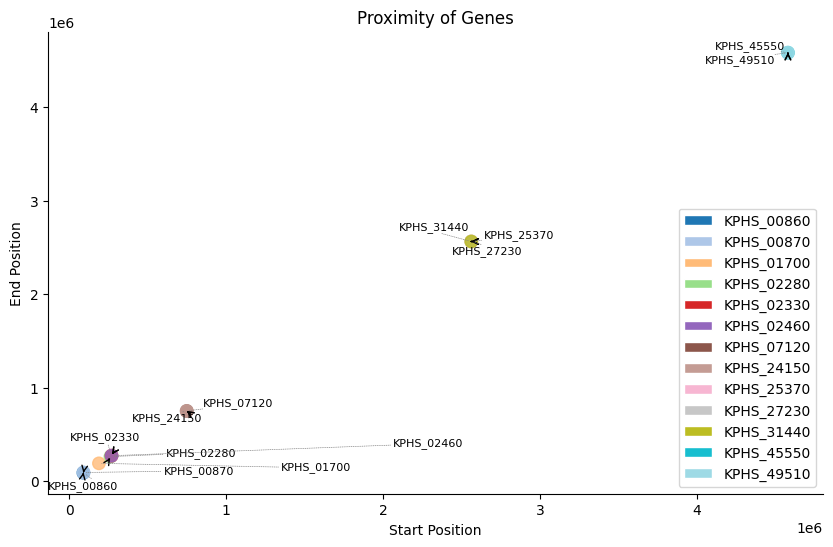

In [82]:
def plot_intervals(intervals):
    # Prepare data for plotting
    labels = [interval[0] for interval in intervals]
    starts = np.array([interval[1] for interval in intervals])
    ends = np.array([interval[2] for interval in intervals])
    strands = [interval[3] for interval in intervals]

    # Create a color map for unique colors
    color_map = plt.cm.get_cmap('tab20', len(intervals))

    fig, ax = plt.subplots()

    # Plot the intervals as a scatter plot with intensified colors
    scatter = ax.scatter(starts, ends, c=range(len(intervals)), cmap='tab20', alpha=0.8, s=80)

    # Add labels with arrows to the scatter plot
    texts = []
    arrows = []
    for i, (x, y, label) in enumerate(zip(starts, ends, labels)):
        texts.append(ax.text(x, y, label, ha='center', va='center', fontsize=8))

        # Find nearby points
        nearby_indices = np.where((np.abs(starts - x) < 10000) & (np.abs(ends - y) < 10000) & (np.arange(len(intervals)) != i))[0]
        if len(nearby_indices) > 0:
            nearby_x = starts[nearby_indices]
            nearby_y = ends[nearby_indices]

            # Calculate angle between points
            angles = np.arctan2(nearby_y - y, nearby_x - x)
            angles = np.degrees(angles)

            # Sort angles in clockwise direction
            sorted_indices = np.argsort(angles)
            nearby_x = nearby_x[sorted_indices]
            nearby_y = nearby_y[sorted_indices]
            angles = angles[sorted_indices]

            # Find the closest angle
            angles = np.concatenate([angles, [angles[0] + 360]])
            diff_angles = np.diff(angles)
            closest_angle_idx = np.argmin(diff_angles)

            # Add arrow pointing in the clockwise direction
            arrow = ax.annotate('', xy=(nearby_x[closest_angle_idx], nearby_y[closest_angle_idx]),
                                xytext=(x, y), arrowprops=dict(arrowstyle='->', color='black'))
            arrows.append(arrow)

    # Adjust the position of labels and arrows to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, linestyle=':'))
    adjust_text(arrows, arrowprops=dict(arrowstyle='-', color='black', lw=0.5, linestyle='-'))

    # Set plot aesthetics
    ax.set_xlabel('Start Position')
    ax.set_ylabel('End Position')
    ax.set_title('Proximity of Genes')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Create a legend
    legend_elements = [Patch(facecolor=color_map(i), edgecolor='w', label=label) for i, label in enumerate(labels)]
    ax.legend(handles=legend_elements, loc='lower right')

    # Set the figure size
    fig.set_size_inches(10, 6)
    # Show the plot
    plt.show()

plot_intervals(intervals)

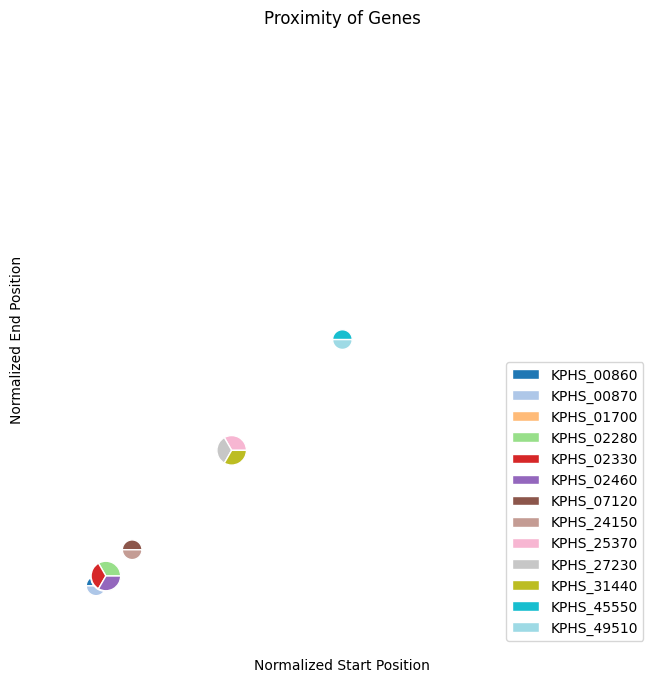

In [98]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
from matplotlib.patches import Patch

def plot_intervals(intervals):
    # Prepare data for plotting
    labels = [interval[0] for interval in intervals]
    starts = np.array([interval[1] for interval in intervals])
    ends = np.array([interval[2] for interval in intervals])
    strands = [interval[3] for interval in intervals]

    # Normalize the data
    starts = (starts - starts.min()) / (starts.max() - starts.min())
    ends = (ends - ends.min()) / (ends.max() - ends.min())

    # Create a color map for unique colors
    color_map = plt.cm.get_cmap('tab20', len(intervals))

    fig, ax = plt.subplots()

    # Plot the intervals as a scatter plot with intensified colors
    scatter = ax.scatter(starts, ends, c=range(len(intervals)), cmap='tab20', alpha=0.0, s=80)

    # Add mini pie charts in place of overlapping points
    for i, (x, y, label) in enumerate(zip(starts, ends, labels)):
        nearby_indices = np.where((np.abs(starts - x) < 0.01) & (np.abs(ends - y) < 0.01))[0]
        nearby_colors = [color_map(idx) for idx in nearby_indices]
        radius = min(0.02*len(nearby_indices), 0.5)  # Limit the maximum radius
        ax.pie([1]*len(nearby_indices), center=(x, y), colors=nearby_colors, radius=radius, wedgeprops=dict(edgecolor='w'))

    # Set plot aesthetics
    ax.set_xlabel('Normalized Start Position')
    ax.set_ylabel('Normalized End Position')
    ax.set_title('Proximity of Genes')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Create a legend
    legend_elements = [Patch(facecolor=color_map(i), edgecolor='w', label=label) for i, label in enumerate(labels)]
    ax.legend(handles=legend_elements, loc='lower right')

    # Set the figure size
    fig.set_size_inches(8, 8)

    # Show the plot
    plt.show()

plot_intervals(intervals)
